In [1]:
import os
import time
import sys

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

## Generate synthetic data

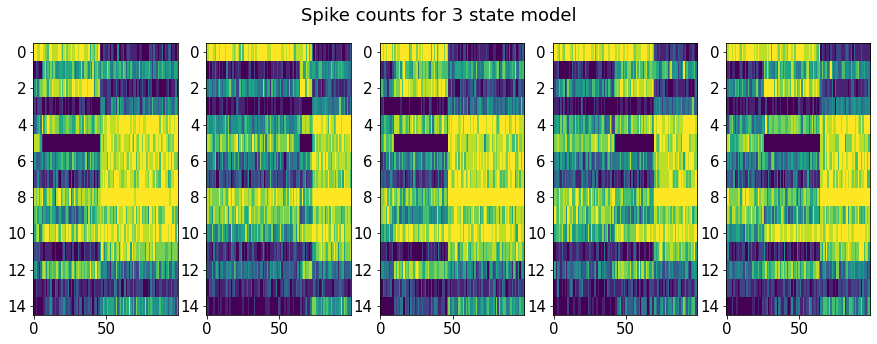

In [257]:
# Some poisson spiking
length = 1000
bin_width = 10
states = 3
nrns = 15
tastes = 4
trials = 20
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [258]:
spike_array.shape

(4, 20, 15, 100)

In [259]:
true_tau.shape

(4, 20, 3)

In [297]:
taste = 0
thinning = 10
wanted_trials = 20
nrn_inds = np.array([2,5,12])

wanted_dat = data_array[taste_ind,:,nrn_inds]
wanted_dat = wanted_dat[...,::thinning]
wanted_dat_psth = wanted_dat.copy()
wanted_dat = wanted_dat[:,:wanted_trials]
wanted_dat.shape

(3, 20, 100)

In [298]:
# wanted_r = true_r[taste_ind,:,nrn_inds]
# wanted_r = wanted_r[...,::thinning]
# wanted_r = wanted_r[:,:wanted_trials]
# wanted_r.shape

wanted_tau = state_inds[taste_ind, :wanted_trials]
wanted_tau = wanted_tau//10
wanted_tau.shape

(20, 4)

In [299]:
# Create heatmap for states
# We can then mask the heatmap and plot it on the same axes
print(wanted_tau.shape)
state_map = np.zeros((wanted_tau.shape[0],int(wanted_tau.max(axis=None))))
inds = list(np.ndindex(wanted_tau.shape))
for trial_num in range(wanted_tau.shape[0]):
    for change_num in range(wanted_tau.shape[1]-1):
        time_lims = wanted_tau[trial_num, change_num : change_num + 2]
        state_map[trial_num, time_lims[0]:time_lims[1]] = change_num

(20, 4)


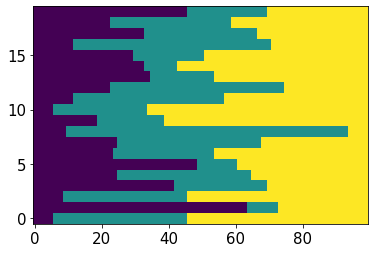

In [300]:
vz.imshow(state_map)

In [301]:
shuffle_inds = [np.arange(wanted_trials) for i in range(len(nrn_inds))]
shuffle_inds = [np.random.permutation(x) for x in shuffle_inds]

trial_shuffled_dat = np.stack(
        [x[inds] for inds,x in zip(shuffle_inds,wanted_dat)]
)
trial_shuffled_dat.shape

(3, 20, 100)

In [302]:
state_mask = np.ones(state_map.shape)
state_mask[0] = 0
masked_state_map = np.ma.array(state_map, mask = state_mask)
#vz.imshow(state_mask, cmap = 'viridis')

In [303]:
# vz.imshow(state_map, cmap = 'viridis')

In [304]:
#vz.imshow(masked_state_map, cmap = 'viridis')

In [305]:
shuffle_state_mask = np.ones((len(nrn_inds),*state_map.shape))
for this_inds in shuffle_inds:
    shuffle_state_mask[:,np.where(this_inds==0)[0]] = 0

In [306]:
# vz.firing_overview(shuffle_state_mask)

In [307]:
trial_shuffled_state_map = np.stack(
        [state_map[inds] for inds in shuffle_inds]
)

In [308]:
# vz.firing_overview(trial_shuffled_state_map, cmap = 'viridis')

In [309]:
masked_shuffled_state_maps = [np.ma.array(x, mask = this_mask) \
                              for x,this_mask in zip(trial_shuffled_state_map,shuffle_state_mask)]

In [310]:
spike_shuffled_dat = wanted_dat.copy()
spike_shuffled_dat = np.moveaxis(spike_shuffled_dat,1,2)
inds = list(np.ndindex(spike_shuffled_dat.shape[:2]))
for this_ind in inds:
    spike_shuffled_dat[this_ind] = np.random.permutation(spike_shuffled_dat[this_ind])
spike_shuffled_dat = np.moveaxis(spike_shuffled_dat,1,2)
spike_shuffled_dat.shape

(3, 20, 100)

In [311]:
psths = np.sum(wanted_dat_psth,axis=1)
psths.shape
#smooth_psths = savgol_filter(psths, window_length = 21, polyorder = 3) 

(3, 100)

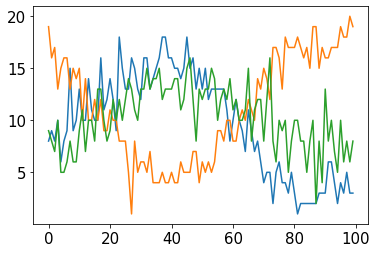

In [312]:
plt.plot(psths.T)
#plt.plot(smooth_psths.T)

In [313]:
spike_shuffled_dat.shape

(3, 20, 100)

In [314]:
wanted_spike_shuffle = spike_shuffled_dat[:,0]
kern = np.ones(10)/10
wanted_psths = np.stack([np.convolve(x,kern, mode = 'same') for x in wanted_spike_shuffle])
wanted_psths.shape

(3, 100)

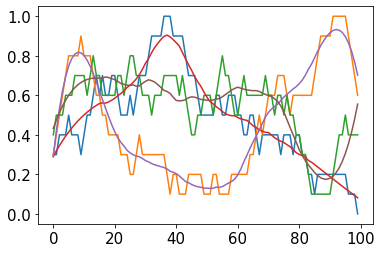

In [315]:
smooth_wanted_psths = savgol_filter(wanted_psths, window_length = 31, polyorder = 3) 
plt.plot(wanted_psths.T)
plt.plot(smooth_wanted_psths.T)

In [316]:
smooth_psths_array = np.broadcast_to(smooth_wanted_psths[:,np.newaxis], shuffle_state_mask.shape)
masked_smooth_psths_array = [np.ma.array(x, mask = state_mask) for x in smooth_psths_array]

In [345]:
# Plot states for first trial
#this_lims = wanted_tau[0]

fontsize = 15
plt.rcParams.update({'font.size': fontsize})

trials = 3
fig,ax = plt.subplots(3,trials, figsize = (13,4), sharex=True, sharey='row')

# Generate data
actual = np.stack([[wanted_dat[nrn,trial] for nrn in range(len(nrn_inds))] for trial in range(trials)])
trial_shuffled = np.stack([[trial_shuffled_dat[nrn,trial] for nrn in range(len(nrn_inds))] for trial in range(trials)])
spike_shuffled = np.stack([[spike_shuffled_dat[nrn,trial] for nrn in range(len(nrn_inds))] for trial in range(trials)])

for i in range(trials):
    ax[0,i] = vz.raster(ax[0,i],actual[i], marker = '|', color = 'k')
    ax[1,i] = vz.raster(ax[1,i],trial_shuffled[i], marker = '|', color = 'k')
    ax[2,i] = vz.raster(ax[2,i],spike_shuffled[i], marker = '|', color = 'k')
    
    # Plot states for first trial
    #for j in range(len(this_lims)-1):
    im = ax[0,i].imshow(np.broadcast_to(state_map[i][np.newaxis,:], (len(nrn_inds), len(state_map[0]))),
                                        aspect='auto', interpolation = 'nearest', alpha= 0.5)
    ax[1,i].imshow(trial_shuffled_state_map[:,i], aspect='auto', interpolation = 'nearest', alpha= 0.5)
    ax[2,i].imshow(np.tile(np.linspace(-0,2,actual.shape[-1]), (len(nrn_inds),1)), aspect='auto', interpolation = 'nearest', alpha= 0.5)


for i in range(3):
    plt.sca(ax[i,0])
    plt.yticks([0,1,2], labels = [0,1,2])
    
#ax[0,0].set_ylabel('Neuron Num')
ax[1,0].set_ylabel('Neuron Num')
#ax[2,0].set_ylabel('Neuron Num')
ax[2,0].set_xlabel('Time (A.U.)')
ax[2,1].set_xlabel('Time (A.U.)')
ax[2,2].set_xlabel('Time (A.U.)')


wanted_bbox =dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )

ax[0,2].text(110, 1, "Actual Data", size=10, rotation=0.,
         ha="left", va="center", bbox = wanted_bbox, fontsize = fontsize)
ax[1,2].text(110, 1, "Trial Shuffle", size=10, rotation=0.,
         ha="left", va="center", bbox = wanted_bbox, fontsize = fontsize)
ax[2,2].text(110, 1, "Spike Shuffle", size=10, rotation=0.,
         ha="left", va="center", bbox = wanted_bbox, fontsize = fontsize)

plt.tight_layout()
fig.savefig('simulated_shuffling_example2.svg', format = 'svg', dpi = 300)
plt.close(fig)
# #plt.colorbar(im)

In [342]:
# Plot states for first trial
#this_lims = wanted_tau[0]

fontsize = 15
plt.rcParams.update({'font.size': fontsize})

fig,ax = plt.subplots(1,len(nrn_inds), figsize = (13,2), sharex=True, sharey='row')
for i in range(len(nrn_inds)):
    ax[i].plot(smooth_wanted_psths[i])
    
plt.tight_layout()
fig.savefig('simulated_shuffling_example2_psths.svg', format = 'svg', dpi = 300)
plt.close(fig)

In [318]:
# # Plot states for first trial
# #this_lims = wanted_tau[0]

# fontsize = 15
# plt.rcParams.update({'font.size': fontsize})

# fig,ax = plt.subplots(4,len(nrn_inds), figsize = (7,13), sharex=True, sharey='row')
# for i in range(len(nrn_inds)):
#     ax[0,i].plot(smooth_wanted_psths[i])
#     ax[1,i] = vz.raster(ax[1,i],wanted_dat[i], marker = '|', color = 'k')
#     ax[2,i] = vz.raster(ax[2,i],trial_shuffled_dat[i], marker = '|', color = 'k')
#     ax[3,i] = vz.raster(ax[3,i],spike_shuffled_dat[i], marker = '|', color = 'k')
    
#     # Plot states for first trial
#     #for j in range(len(this_lims)-1):
#     im = ax[1,i].imshow(masked_state_map, aspect='auto', interpolation = 'nearest', alpha= 0.5)
#     ax[2,i].imshow(masked_shuffled_state_maps[i], aspect='auto', interpolation = 'nearest', alpha= 0.5)
#     ax[3,i].imshow(masked_smooth_psths_array[i], aspect='auto', interpolation = 'nearest', alpha= 0.5)
    
# ax[0,0].set_title('Neuron 1')
# ax[0,1].set_title('Neuron 2')
# ax[0,0].set_ylabel('Firing Rate (A.U.)')
# ax[1,0].set_ylabel('Trial Num')
# ax[2,0].set_ylabel('Trial Num')
# ax[3,0].set_ylabel('Trial Num')
# ax[3,0].set_xlabel('Time (A.U.)')
# ax[3,1].set_xlabel('Time (A.U.)')


# wanted_bbox =dict(boxstyle="round",
#                    ec=(1., 0.5, 0.5),
#                    fc=(1., 0.8, 0.8),
#                    )

# ax[0,1].text(110, 0.5, "Trial Averaged Firing Rate", size=10, rotation=270.,
#          ha="center", va="center", bbox = wanted_bbox, fontsize = fontsize)
# ax[1,1].text(110, 2, "Actual Data", size=10, rotation=270.,
#          ha="center", va="center", bbox = wanted_bbox, fontsize = fontsize)
# ax[2,1].text(110, 2, "Trial Shuffle", size=10, rotation=270.,
#          ha="center", va="center", bbox = wanted_bbox, fontsize = fontsize)
# ax[3,1].text(110, 2, "Spike Shuffle", size=10, rotation=270.,
#          ha="center", va="center", bbox = wanted_bbox, fontsize = fontsize)

# #plt.tight_layout()
# #fig.savefig('simulated_shuffling_example.svg', format = 'svg', dpi = 300)
# #plt.close(fig)
# #plt.colorbar(im)